In [1]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

In [2]:
from diorep import contrast,reduceNoise
from diorep.arrman import compute_db
from diorep.arrman import get_image
from diorep.arrman import padSample
import pandas as pd
import scipy.io.wavfile as wav
import numpy as np
import IPython.display as ipd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import random
import math
import decimal
from diorep.arrplot import plotSignal
from diorep.fmanip import clip_category,gen_noise_file,get_amplitude
from diorep.arrman import lenArray
from diorep.reduceNoise import retNoiseClip,reduceNoiseNR
from diorep. fmanip import assign_probability
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import math
import librosa
from diorep.arrman import get_melspectr,random_power,mono_to_color,normalize
random.seed(123)
from diorep.arrman import get_wav_transforms
from diorep.fmanip import generate_bkgnoise
import os
from diorep.fmanip import silence_removal

C:\Users\hamhamm\anaconda3\envs\tf_gpu\lib\site-packages\noisereduce\noisereduce.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
train=pd.read_csv('latest_keywords_new.csv')


In [4]:
train.head()

,fn,label
0,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi
1,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi
2,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi
3,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi
4,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi


In [5]:
for i in range(len(train)):
    _,arr=wav.read(train.fn.loc[i])
    arr=arr.astype(np.float32)
    wav.write(train.fn.loc[i],22050,arr)

In [6]:
class HyperParameters():
    def __init__(self,bias=4,n_clip_length=500,audibility_threshold=50):
        """
        PARAMETERS
        ----------
        bias: Bias parameter for the Noise Threshold
        n_clip_length: Noise Clip Length
        """
        self.bias=bias
        self.sig_1p='audio_files/01RD8LR.wav'
        self.sig_2p='audio_files/0259OO7.wav'
        self.bkg_N='audio_files/SMNDURA.wav'
        self.sr=22050
        self.amp_1N=0.007746608
        self.amp_2N_ref=0.00015370044
        self.noise_threshold=compute_db(self.amp_1N,self.amp_2N_ref) + self.bias
        self.NOISE_DIR='Noise_clip_latest'
        self.n_clip_length=n_clip_length
        self.audibility_threshold=audibility_threshold
        self.bkg_N_path='bkg_Noise_latest'


class HyperParamsTransform():
    """
    Class to define the Hyper-parameters
    """
    def __init__(self,n_mels,img_width,padSamplePath='padSampleDir',sig_len_max=60858):
        """
        PARAMETERS
        ----------
        n_mels: n_mels
        hop_length: hop_length
        INIT
        ----
        img_width
        n_mels
        hop_length
        padSamplePath: path to save padded input
        """
        self.n_mels=n_mels
        self.img_width=img_width 
        self.sig_len_max=sig_len_max
        self.hop_length= int(math.ceil(self.sig_len_max/self.img_width))
        self.sr=22050
        self.div_coef=100
        self.padSamplePath=padSamplePath
        

In [7]:
hp=HyperParameters(bias=60)
hpT=HyperParamsTransform(224,445,'padSampleDir_latest_bkg',sig_len_max=55566)

In [8]:
# print the noise Threshold
print(f"The Noise Threshold in Decibel is: {hp.noise_threshold} dB ")

The Noise Threshold in Decibel is: 94 dB 


# Generating features

In [9]:
train['Sample_Length']=train.fn.transform(lambda x: lenArray(x) )

# Generating the Noise File

In [10]:
train['Noise_fn']=train.fn.transform(lambda x: gen_noise_file(x,hp.NOISE_DIR,hp.n_clip_length))

# Generating amplitude of the Noise Signal

In [11]:
train['Noise_Amplitude']=train.Noise_fn.transform(lambda x: get_amplitude(x))

# Determining noise file in decibel

In [12]:
train['dB_Noise_SPL']=train.Noise_Amplitude.transform(lambda x: compute_db(x,hp.amp_2N_ref))

In [13]:
train['dB_Noise_SPL'].max()

166

In [14]:
train['dB_Noise_SPL'].min()

76

# Determining the Clip Group

In [15]:
train['Clip_Group']=train.dB_Noise_SPL.transform(lambda x: clip_category(x,hp.noise_threshold,mid=126))

# Assigning probability Levels to each Group

In [16]:
train['Prob_Accuracy']=train.Clip_Group.transform(lambda x: assign_probability(x))

In [17]:
train.Sample_Length.max()

55566

In [18]:
train[(train.dB_Noise_SPL < 166) &(train.dB_Noise_SPL > 76)]

,fn,label,Sample_Length,Noise_fn,Noise_Amplitude,dB_Noise_SPL,Clip_Group,Prob_Accuracy
0,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55053,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,57.0,111,good,0.7
1,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55181,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,62.0,112,good,0.7
2,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55117,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,66.0,112,good,0.7
3,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55181,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,102.0,116,good,0.7
4,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55181,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,80.0,114,good,0.7
...,...,...,...,...,...,...,...,...
1735,latest_keywords_new\latest_keywords\sikungula/...,sikungula,54243,Noise_clip_latest/5aa4893526794a73a3ed0a7ebba2...,143.0,119,good,0.7
1736,latest_keywords_new\latest_keywords\sikungula/...,sikungula,54243,Noise_clip_latest/eb702740d41f4f389192ec5c6a3a...,346.0,127,bad,0.2
1737,latest_keywords_new\latest_keywords\sikungula/...,sikungula,54243,Noise_clip_latest/eb702740d41f4f389192ec5c6a3a...,350.0,127,bad,0.2
1738,latest_keywords_new\latest_keywords\sikungula/...,sikungula,54243,Noise_clip_latest/eb702740d41f4f389192ec5c6a3a...,36.0,107,good,0.7


# Determining the decibel of the Audio File


In [19]:
# Get the Audio Amplitude
train['Audio_amplitude']=train.fn.transform(lambda x: get_amplitude(x,100))
train['dB_Audio_SPL']=train.Audio_amplitude.transform(lambda x: compute_db(x,hp.amp_2N_ref))

In [20]:
train.head()

,fn,label,Sample_Length,Noise_fn,Noise_Amplitude,dB_Noise_SPL,Clip_Group,Prob_Accuracy,Audio_amplitude,dB_Audio_SPL
0,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55053,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,57.0,111,good,0.7,30480.0,165
1,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55181,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,62.0,112,good,0.7,28551.0,165
2,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55117,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,66.0,112,good,0.7,29217.0,165
3,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55181,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,102.0,116,good,0.7,10222.0,156
4,latest_keywords_new\latest_keywords\abalimi/1b...,abalimi,55181,Noise_clip_latest/1b5a69c4b88b41eb9577a656e11b...,80.0,114,good,0.7,26144.0,164


# PadSample

In [21]:
from diorep.arrman import padSample

In [22]:
def pad(train,hpT):
    dir_p=[]
    if not os.path.exists(hpT.padSamplePath):
        os.makedirs(hpT.padSamplePath)
    for i in range(len(train)):
        _=padSample(train.Sample_Length.loc[i],train.Sample_Length.max(),train.fn.loc[i]) 
        fname=train.fn.loc[i].split('/')
        fname=fname[1]
        fname=hpT.padSamplePath + '/' + fname
        dir_p.append(fname)

        wav.write(fname,hp.sr,_)
    return np.array(dir_p)
    

In [23]:
train['fn']=pad(train,hpT)

In [24]:
train['Sample_Length']=train.fn.transform(lambda x: lenArray(x) )

# Generating Background Noise

In [25]:
from diorep.fmanip import random_key_gen

In [26]:

if not os.path.exists(hp.bkg_N_path):
    os.makedirs(hp.bkg_N_path)
for i in range(len(train)):
    noise=generate_bkgnoise(train,signal_length=55566,lower_dB_threshold=66,higher_dB_threshold=166)
    key=random_key_gen(7) + '.wav'
    wav.write(os.path.join(hp.bkg_N_path,key),hp.sr,noise)
    

11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
11025
1102

In [27]:
train.Sample_Length.max()

55566

# Generating MelSpectrogram

In [28]:
from diorep.arrman import mono_to_color,get_image,get_melspectr,normalize
import librosa.display
from diorep.saug import pitchShift,shiftTime,timeStretch
from diorep.reduceNoise import reduceNoiseNR
from diorep.arrman import get_wav_transforms

# bkg_Noise

In [29]:
import random 
random.seed(42)

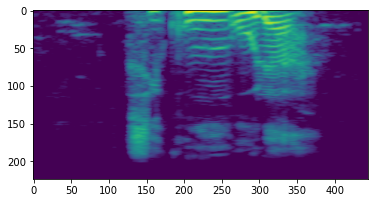

In [30]:
image_Path='bkg_mel_latest'
noise_path='bkg_Noise_latest'
mel_=[]    
transform=get_wav_transforms(noise_path)

if not os.path.exists(image_Path):
    os.makedirs(image_Path)
for i in range(1464,1740):
    _,arr=wav.read(train.fn.loc[i])
    a=reduceNoiseNR(hp.sr,arr,500)
    #a=transform(a,hp.sr)
    a=get_image(arr,hpT)
    a=mono_to_color(a)
    a=normalize(a)
    img=plt.imshow(a[0])
    fname=train.fn.loc[i].split('/')
    fname=fname[1]
    fname=fname.split('.')
    fname=fname[0]
    fname=image_Path + '/' + fname + '.png'
    mel_.append(fname)
    plt.savefig(fname)